# Reproduction FastGCN Paper



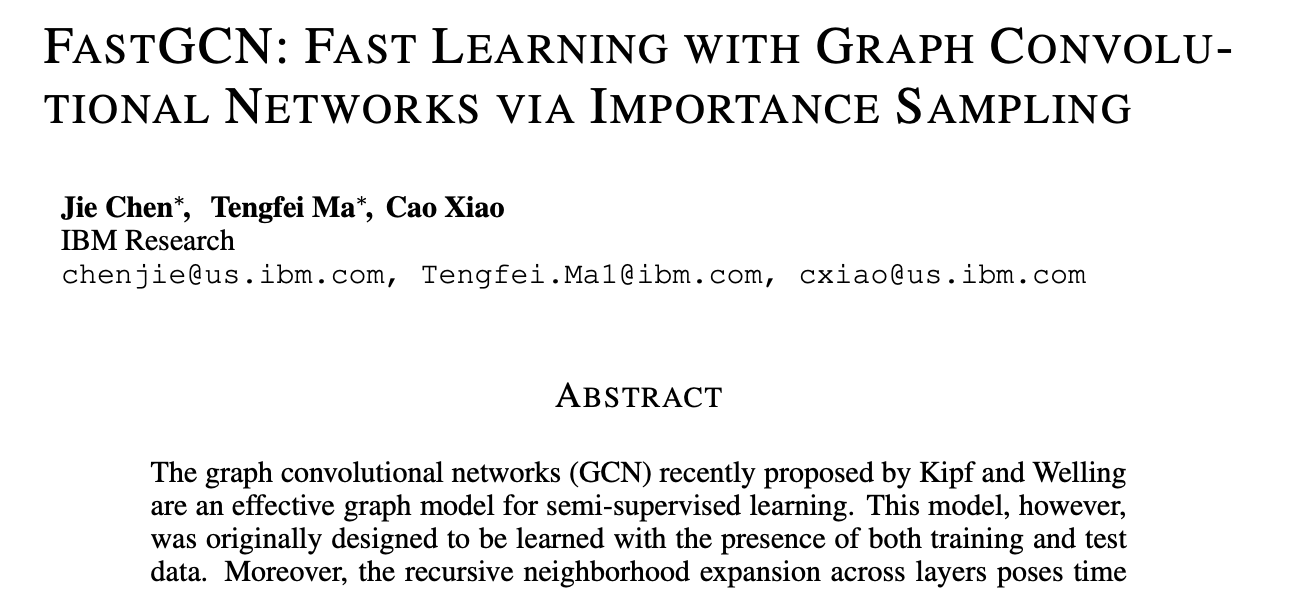

## Notes
- How well documented does code have to be?
- Reddti dataset too big for RAM

-> Check variance of sampled nodes!

## Imports


In [ ]:
!pip install torch-geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid, Reddit
from sklearn.metrics import f1_score
import numpy as np
import os.path as osp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.6 MB/s eta 0:00:00


## Configuration & Hyperparameters

In [ ]:
DATASET_CONFIG = {
    'Cora': {
        'hidden_channels': 16,
        'sample_size': 400,
        'batch_size': 256,
        'lr': 0.01,
        'weight_decay': 5e-4,
        'root': '/tmp/Cora'
    },
    'Pubmed': {
        'hidden_channels': 16,
        'sample_size': 100,
        'batch_size': 1024,
        'lr': 0.01,
        'weight_decay': 5e-4,
        'root': '/tmp/Pubmed'
    },
    'Reddit': {
        'hidden_channels': 128,
        'sample_size': 400,
        'batch_size': 256,
        'lr': 0.01,
        'weight_decay': 0,
        'root': '/tmp/Reddit'
    }
}


## Data Loading & Split Logic


In [ ]:
def get_dataset(name):
    cfg = DATASET_CONFIG[name]

    if name == 'Reddit':
        dataset = Reddit(root=cfg['root'])
        data = dataset[0]

        return dataset, data

    else: # Cora or Pubmed
        dataset = Planetoid(root=cfg['root'], name=name)
        data = dataset[0]
        data.train_mask = ~(data.val_mask | data.test_mask)

        return dataset, data

## Utilities: Precomputation & Probabilities


In [ ]:
def compute_fastgcn_probs(edge_index, num_nodes):
    """
    Computes importance sampling distribution q
    """
    # Add self loops for degree calculation
    loop_index = torch.arange(num_nodes, device=edge_index.device).unsqueeze(0).repeat(2, 1)
    edge_index_sl = torch.cat([edge_index, loop_index], dim=1)
    row, col = edge_index_sl

    #Calculate degrees
    deg = torch.bincount(row, minlength=num_nodes).float()

    # sum over columns (incoming edges) for the norm + normalization
    values = 1.0 / (deg[row] * deg[col])
    col_norms = torch.zeros(num_nodes, device=edge_index.device)
    col_norms.scatter_add_(0, col, values)

    #normalize
    probs = col_norms / col_norms.sum()

    return probs, deg, edge_index_sl

@torch.no_grad()
def precompute_first_layer(x, edge_index, deg):
    """
    precomputes A_hat * H (0)
    """
    row, col = edge_index
    norm = 1.0 / torch.sqrt(deg[row] * deg[col])

    out = torch.zeros((x.size(0), x.size(1)), device=x.device)
    out.index_add_(0, row, norm.unsqueeze(1) * x[col])
    return out

@torch.no_grad()
def precompute_first_layer(x, edge_index, deg):
    row, col = edge_index
    num_nodes = x.size(0)

    # normalization
    norm = 1.0 / torch.sqrt(deg[row] * deg[col])

    A_sparse = torch.sparse_coo_tensor(edge_index, norm, (num_nodes, num_nodes)).to(x.device)
    return torch.sparse.mm(A_sparse, x)

## Model Definition


In [ ]:
class FastGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.W = nn.Linear(in_channels, out_channels, bias=False)

    def forward(self, x, edge_index, deg, sampled_nodes=None, probs=None, prev_nodes=None, num_nodes=None):
        # for training use sampled nodes
        if self.training and sampled_nodes is not None:
            row, col = edge_index
            mask = (torch.isin(row, prev_nodes) & torch.isin(col, sampled_nodes))
            row, col = row[mask], col[mask]

            norm = 1.0 / torch.sqrt(deg[row] * deg[col])
            weight = norm / (probs[col] * len(sampled_nodes))

            h_u = self.W(x[col])

            u_prev, _ = torch.unique(prev_nodes, sorted=True, return_inverse=True)
            prev_map = torch.full((num_nodes,), -1, dtype=torch.long, device=x.device)
            prev_map[u_prev] = torch.arange(len(u_prev), device=x.device)
            local_row = prev_map[row]

            out = torch.zeros(len(prev_nodes), self.W.out_features, device=x.device)
            out.index_add_(0, local_row, weight.unsqueeze(1) * h_u)
            return out
        # for inferecne use full neighbourhood
        else:
            row, col = edge_index
            norm = 1.0 / torch.sqrt(deg[row] * deg[col])
            h = self.W(x)
            out = torch.zeros((x.size(0), self.W.out_features), device=x.device)
            out.index_add_(0, row, norm.unsqueeze(1) * h[col])
            return out

class FastGCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, sample_size):
        super().__init__()
        self.sample_size = sample_size
        #Layer 1 is precomputed
        self.W1 = nn.Linear(in_channels, hidden_channels, bias=False)
        self.conv2 = FastGCNLayer(hidden_channels, out_channels)

    def forward(self, x_precomputed, edge_index, deg, probs, target_nodes, num_nodes):
        if self.training:
            # apply weights to precomputed features
            h1 = F.relu(self.W1(x_precomputed))

            # sample nodes for Layer 2
            sampled_l1 = torch.multinomial(probs, self.sample_size, replacement=True)

            # conv Layer 2 using sampled nodes
            out = self.conv2(h1, edge_index, deg, sampled_l1, probs, target_nodes, num_nodes)
        else:
            h1 = F.relu(self.W1(x_precomputed))
            out = self.conv2(h1, edge_index, deg)
            out = out[target_nodes]

        return F.log_softmax(out, dim=1)



## Training Run Definition

In [ ]:
import time

def run(dataset_name='Pubmed'):
    print(f"--- Running FastGCN on {dataset_name} ---")
    cfg = DATASET_CONFIG[dataset_name]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # load Data
    dataset, data = get_dataset(dataset_name)
    data = data.to(device)

    print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}, Features: {data.num_features}")
    print(f"Train nodes: {data.train_mask.sum().item()}, Val: {data.val_mask.sum().item()}, Test: {data.test_mask.sum().item()}")

    # preprocessing
    print("Computing probabilities...")
    probs, deg, edge_index = compute_fastgcn_probs(data.edge_index, data.num_nodes)

    print("Precomputing first layer (A_hat * X)...")
    x_precomputed = precompute_first_layer(data.x, edge_index, deg)

    print("Defining model...")
    model = FastGCNModel(
        in_channels=data.num_features,
        hidden_channels=cfg['hidden_channels'],
        out_channels=dataset.num_classes,
        sample_size=cfg['sample_size']
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])

    def train():
        model.train()
        optimizer.zero_grad()
        train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
        out = model(x_precomputed, edge_index, deg, probs, train_idx, data.num_nodes)
        loss = F.nll_loss(out, data.y[train_idx])
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def test():
        model.eval()
        def get_f1(mask):
            idx = mask.nonzero(as_tuple=False).view(-1)
            out = model(x_precomputed, edge_index, deg, probs, idx, data.num_nodes)
            pred = out.argmax(dim=1).cpu().numpy()
            label = data.y[idx].cpu().numpy()
            return f1_score(label, pred, average='micro')

        return get_f1(data.train_mask), get_f1(data.val_mask), get_f1(data.test_mask)

    print("Starting training...")
    total_train_time = 0
    num_epochs = 201

    for epoch in range(0, num_epochs):
        start_time = time.time()

        loss = train()

        # Calculate duration
        epoch_duration = time.time() - start_time
        total_train_time += epoch_duration

        if epoch % 20 == 0:
            tr, va, te = test()
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Time: {epoch_duration:.4f}s | Train F1: {tr:.4f} | Val F1: {va:.4f} | Test F1: {te:.4f}")

    avg_time = total_train_time / num_epochs
    print(f"\n--- Training Complete ---")
    print(f"Average time per epoch: {avg_time:.4f}s")
    return te

In [ ]:
a1 = run('Pubmed')
a2 = run('Pubmed')
a3 = run('Pubmed')
b1 = run('Cora')
b2 = run('Cora')
b3 = run('Cora')

print(f"Mean_Pubmed: {np.mean([a1, a2, a3])}, Std_Pubmed: {np.std([a1, a2, a3])}")
print(f"Mean_Cora: {np.mean([b1, b2, b3])}, Std_Cora: {np.std([b1, b2, b3])}")


Running experiments for sample size: 128...
--- Running FastGCN on Cora ---


Processing...
Done!


Nodes: 2708, Edges: 10556, Features: 1433
Train nodes: 1208, Val: 500, Test: 1000
Computing probabilities...
Precomputing first layer (A_hat * X)...
Defining model...
Starting training...
Epoch 000 | Loss: 1.9489 | Time: 0.1583s | Train F1: 0.3030 | Val F1: 0.2700 | Test F1: 0.2820
Epoch 020 | Loss: 1.7246 | Time: 0.0422s | Train F1: 0.9272 | Val F1: 0.8600 | Test F1: 0.8600
Epoch 040 | Loss: 1.6635 | Time: 0.0676s | Train F1: 0.9305 | Val F1: 0.8520 | Test F1: 0.8550
Epoch 060 | Loss: 1.6755 | Time: 0.0812s | Train F1: 0.9512 | Val F1: 0.8560 | Test F1: 0.8600
Epoch 080 | Loss: 1.6606 | Time: 0.0234s | Train F1: 0.9561 | Val F1: 0.8600 | Test F1: 0.8590
Epoch 100 | Loss: 1.6535 | Time: 0.0157s | Train F1: 0.9652 | Val F1: 0.8740 | Test F1: 0.8510
Epoch 120 | Loss: 1.6217 | Time: 0.0156s | Train F1: 0.9528 | Val F1: 0.8620 | Test F1: 0.8590
Epoch 140 | Loss: 1.6331 | Time: 0.0174s | Train F1: 0.9586 | Val F1: 0.8580 | Test F1: 0.8520
Epoch 160 | Loss: 1.6130 | Time: 0.0152s | Train F1:

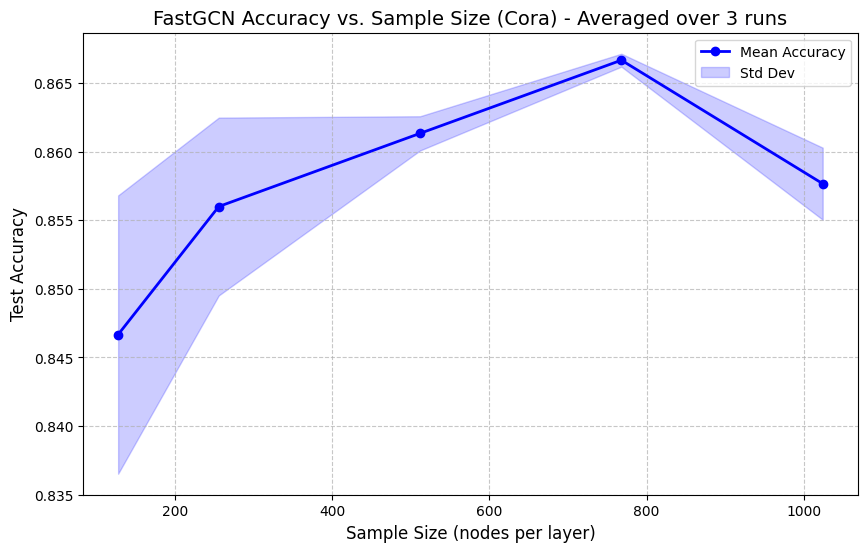

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

results_all_runs = []
sample_sizes = [128, 256, 512, 768, 1024]
num_runs = 3

for size in sample_sizes:
    current_size_results = []
    print(f"Running experiments for sample size: {size}...")

    for i in range(num_runs):
        DATASET_CONFIG = {
            'Cora': {
                'hidden_channels': 16,
                'sample_size': size,
                'batch_size': 256,
                'lr': 0.01,
                'weight_decay': 5e-4,
                'root': '/tmp/Cora'
            }
        }
        acc = run('Cora')
        current_size_results.append(acc)

    results_all_runs.append(current_size_results)

# rows = sample_size, cols = run_idx
results_arr = np.array(results_all_runs)
avg_results = results_arr.mean(axis=1)
std_results = results_arr.std(axis=1)

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot the average line
plt.plot(sample_sizes, avg_results, marker='o', linestyle='-', color='blue', linewidth=2, label='Mean Accuracy')

# Add a shaded area for standard deviation (shows the variance/noise)
plt.fill_between(sample_sizes, avg_results - std_results, avg_results + std_results, color='blue', alpha=0.2, label='Std Dev')

# Adding labels and titles
plt.title('FastGCN Accuracy vs. Sample Size (Cora) - Averaged over 3 runs', fontsize=14)
plt.xlabel('Sample Size (nodes per layer)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)

# Adding a grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

In [ ]:
print(results_arr)
print(avg_results)
print(std_results)

[[0.839 0.861 0.84 ]
 [0.865 0.85  0.853]
 [0.86  0.861 0.863]
 [0.867 0.867 0.866]
 [0.859 0.854 0.86 ]]
[0.84666667 0.856      0.86133333 0.86666667 0.85766667]
[0.01014342 0.00648074 0.00124722 0.0004714  0.00262467]


Running Pubmed experiments for sample size: 128...
--- Running FastGCN on Pubmed ---


Processing...
Done!


Nodes: 19717, Edges: 88648, Features: 500
Train nodes: 18217, Val: 500, Test: 1000
Computing probabilities...
Precomputing first layer (A_hat * X)...
Defining model...
Starting training...
Epoch 000 | Loss: 1.0992 | Time: 0.0785s | Train F1: 0.4269 | Val F1: 0.4480 | Test F1: 0.4400
Epoch 020 | Loss: 1.0828 | Time: 0.0714s | Train F1: 0.8554 | Val F1: 0.8740 | Test F1: 0.8680
Epoch 040 | Loss: 1.0816 | Time: 0.0514s | Train F1: 0.8638 | Val F1: 0.8820 | Test F1: 0.8590
Epoch 060 | Loss: 1.0833 | Time: 0.0490s | Train F1: 0.8681 | Val F1: 0.8920 | Test F1: 0.8620
Epoch 080 | Loss: 1.0858 | Time: 0.0491s | Train F1: 0.8395 | Val F1: 0.8540 | Test F1: 0.8350
Epoch 100 | Loss: 1.0805 | Time: 0.0495s | Train F1: 0.8583 | Val F1: 0.8840 | Test F1: 0.8490
Epoch 120 | Loss: 1.0803 | Time: 0.0503s | Train F1: 0.8676 | Val F1: 0.8920 | Test F1: 0.8710
Epoch 140 | Loss: 1.0820 | Time: 0.0499s | Train F1: 0.8685 | Val F1: 0.8940 | Test F1: 0.8650
Epoch 160 | Loss: 1.0788 | Time: 0.0493s | Train F1

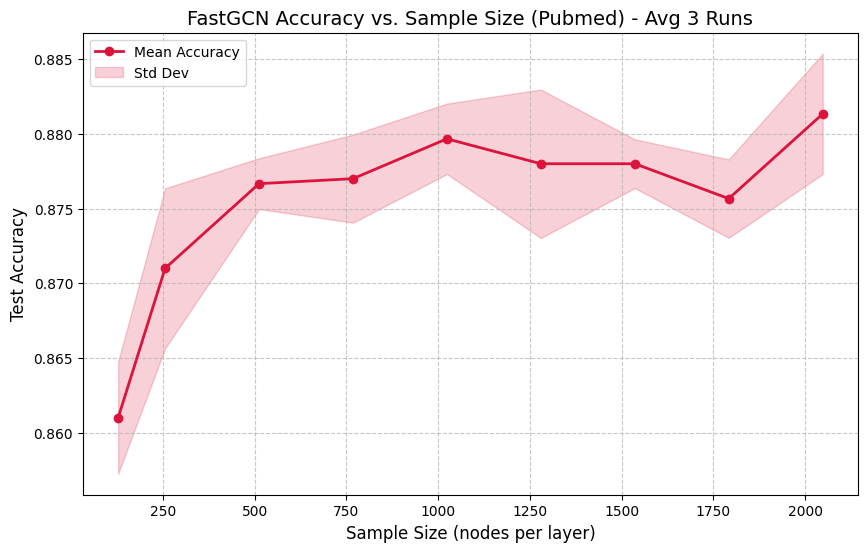

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

results_all_runs = []
sample_sizes = [128, 256, 512, 768, 1024, 1280, 1536, 1792, 2048]
num_runs = 3

for size in sample_sizes:
    current_size_results = []
    print(f"Running Pubmed experiments for sample size: {size}...")

    for i in range(num_runs):
        DATASET_CONFIG = {
          'Pubmed': {
              'hidden_channels': 16,
              'sample_size': size,
              'batch_size': 1024,
              'lr': 0.01,
              'weight_decay': 5e-4,
              'root': '/tmp/Pubmed'
          }
        }
        acc = run('Pubmed')
        current_size_results.append(acc)

    results_all_runs.append(current_size_results)

results_arr = np.array(results_all_runs)
avg_results = results_arr.mean(axis=1)
std_results = results_arr.std(axis=1)

# --- Plotting ---
plt.figure(figsize=(10, 6))

plt.plot(sample_sizes, avg_results, marker='o', linestyle='-', color='crimson', linewidth=2, label='Mean Accuracy')
plt.fill_between(sample_sizes, avg_results - std_results, avg_results + std_results, color='crimson', alpha=0.2, label='Std Dev')

plt.title('FastGCN Accuracy vs. Sample Size (Pubmed) - Avg 3 Runs', fontsize=14)
plt.xlabel('Sample Size (nodes per layer)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

In [ ]:
print(results_arr)
print(avg_results)
print(std_results)

[[0.866 0.86  0.857]
 [0.865 0.878 0.87 ]
 [0.875 0.876 0.879]
 [0.873 0.878 0.88 ]
 [0.878 0.883 0.878]
 [0.882 0.871 0.881]
 [0.876 0.878 0.88 ]
 [0.878 0.877 0.872]
 [0.887 0.879 0.878]]
[0.861      0.871      0.87666667 0.877      0.87966667 0.878
 0.878      0.87566667 0.88133333]
[0.00374166 0.00535413 0.00169967 0.00294392 0.00235702 0.00496655
 0.00163299 0.00262467 0.00402768]


In [ ]:
#Pubmed importance
#sample_sizes = [128, 256, 512, 768, 1024, 1280, 1536, 1792, 2048]
#mean: [0.861      0.871      0.87666667 0.877      0.87966667 0.878
# 0.878      0.87566667 0.88133333]
#std: [0.00374166 0.00535413 0.00169967 0.00294392 0.00235702 0.00496655
# 0.00163299 0.00262467 0.00402768]

# Cora importance
#sample_sizes = [128, 256, 512, 768, 1024]
#mean: [0.84666667 0.856      0.86133333 0.86666667 0.85766667]
#std: [0.01014342 0.00648074 0.00124722 0.0004714  0.00262467]